# 🧠 Digit Generation using Wasserstein GAN with Gradient Penalty (WGAN-GP)


This notebook demonstrates the implementation of a **Wasserstein GAN with Gradient Penalty (WGAN-GP)** to generate handwritten digits. WGAN-GP addresses several stability issues found in traditional GANs, particularly improving training dynamics and reducing mode collapse.

### 🎯 **Objectives**

In this project, I:

1. Implemented a more robust GAN variant — the **Wasserstein GAN with Gradient Penalty**.
2. Trained the WGAN-GP model to generate realistic digit images using the MNIST dataset.
3. Utilized the **Wasserstein loss function (W-loss)** and **gradient penalties** for better convergence and stability.

> 📚 *Fun Fact:* The term "Wasserstein" is derived from mathematician **Leonid Vaseršteĭn**, and is commonly abbreviated as **W** (e.g., WGAN, W-distance, W-loss).


## 🧩 Generator and Critic Overview

I begin by importing the necessary packages and defining helper functions for visualization. The architecture of the **generator** and **critic** is similar to standard GANs. However, in WGAN-GP, we replace the discriminator with a critic that outputs a continuous score instead of a probability.


#### 🔧 Setup: Packages and Visualizations

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

d:\Program Files\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.33013868..1.7827944].


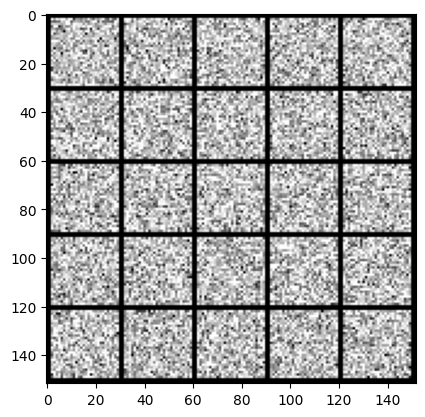

In [3]:
# Simulate 25 grayscale images in [0, 1] range
sample_images = torch.randn(25, 1, 28, 28) * 0.5 + 0.5
show_tensor_images(sample_images)

In [4]:
def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes, 
    which fills the grads list when using model.apply(grad_hook).
    '''
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

#### 🧪 Generator Implementation & Noise Input

The generator network transforms a random noise vector into a synthetic image through a series of transposed convolutional layers. It uses batch normalization and ReLU activations to progressively upscale the latent space representation. The final layer uses a `tanh` activation to produce output values in the range \([-1, 1]\), aligning with the normalized image pixel range.


In [5]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
      n_samples: the number of samples to generate, a scalar
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [6]:
from torchsummary import summary

# Create an instance of your Generator
gen = Generator(z_dim=64, im_chan=1, hidden_dim=64)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen = gen.to(device)

# Show model summary
summary(gen, input_size=(64, 1, 1))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

#### 🧪 Critic Implementation

In WGAN-GP, the critic replaces the traditional discriminator. Unlike standard GANs that output probabilities, the critic produces a scalar value representing the "realness" of the input image. It uses convolutional layers with LeakyReLU activations and batch normalization (excluding the final layer). The architecture compresses input images into a single scalar output without applying a sigmoid activation, in accordance with the Wasserstein loss formulation.


In [7]:
class Critic(nn.Module):
    '''
    Critic Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.make_crit_block(im_chan, hidden_dim),
            self.make_crit_block(hidden_dim, hidden_dim * 2),
            self.make_crit_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a critic block of DCGAN;
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the critic: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

In [8]:
from torchsummary import summary

# Initialize model
critic = Critic(im_chan=1, hidden_dim=128).to('cuda' if torch.cuda.is_available() else 'cpu')

# Print summary
summary(critic, input_size=(1, 28, 28))  # Corrected input size for MNIST images

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 13, 13]           2,176
       BatchNorm2d-2          [-1, 128, 13, 13]             256
         LeakyReLU-3          [-1, 128, 13, 13]               0
            Conv2d-4            [-1, 256, 5, 5]         524,544
       BatchNorm2d-5            [-1, 256, 5, 5]             512
         LeakyReLU-6            [-1, 256, 5, 5]               0
            Conv2d-7              [-1, 1, 1, 1]           4,097
Total params: 531,585
Trainable params: 531,585
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.64
Params size (MB): 2.03
Estimated Total Size (MB): 2.67
----------------------------------------------------------------


#### ⚙️ Training Configuration & Model Initialization

This section defines the core training hyperparameters and initializes the generator and critic models. The MNIST dataset is loaded with normalization to the \([-1, 1]\) range, compatible with the generator's `tanh` output.

**Key Components:**
- `n_epochs`: Total number of training epochs
- `z_dim`: Dimension of the latent noise vector
- `lr`, `beta_1`, `beta_2`: Learning rate and Adam optimizer hyperparameters
- `c_lambda`: Gradient penalty coefficient for WGAN-GP
- `crit_repeats`: Number of critic updates per generator update
- `device`: Training hardware (`cuda` or `cpu`)

The generator and critic are instantiated and optimized using Adam. Weight initialization follows the DCGAN convention with normal distribution for convolutional layers and batch normalization parameters.

In [9]:
from torchvision import datasets, transforms

n_epochs = 100
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# dataset_path = 'mnist_png'

# dataloader = DataLoader(
#     datasets.ImageFolder(root=dataset_path, transform=transform),
#     batch_size=batch_size,
#     shuffle=True
# )

dataset_path = 'mnist_png'

# Load the dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Select 1000 random images
subset_indices = torch.randperm(len(dataset))[:20000]
subset = torch.utils.data.Subset(dataset, subset_indices)

# Create a DataLoader for the subset
dataloader = DataLoader(subset, batch_size=batch_size, shuffle=True)

In [10]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)


#### 📐 Gradient Penalty (WGAN-GP)

To enforce the Lipschitz constraint in Wasserstein GANs with Gradient Penalty (WGAN-GP), we compute gradients of the critic's output with respect to interpolated inputs and penalize deviations from a gradient norm of 1.

**Functions:**

- `get_gradient(crit, real, fake, epsilon)`:  
  Interpolates between real and fake images using a random coefficient `epsilon`, then computes the gradient of the critic's output with respect to these mixed inputs.

- `gradient_penalty(gradient)`:  
  Computes the gradient penalty by measuring how far the L2 norm of the gradient deviates from 1, and returns the mean squared error. This helps regularize the critic and stabilize training.

These functions are essential for robust training of WGAN-GP models by encouraging the critic to behave in a smooth and consistent manner.


In [11]:
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
       
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient


In [12]:

def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    penalty = ((gradient_norm - 1) ** 2).mean()

    return penalty

## 📉 Loss Functions for WGAN-GP

In Wasserstein GANs with Gradient Penalty (WGAN-GP), loss functions for the generator and critic follow the Wasserstein distance objective.

### 🔹 Generator Loss:
- Objective: Maximize the critic's prediction on fake images.
- Formula:  
  \[
  \mathcal{L}_G = -\mathbb{E}[D(G(z))]
  \]
- In code:  
  ```python
  gen_loss = -1. * torch.mean(crit_fake_pred)


In [13]:
def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''

    gen_loss = -1. * torch.mean(crit_fake_pred)

    return gen_loss

In [14]:

def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty 
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''

    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp

    return crit_loss

 18%|█▊        | 29/157 [00:26<01:46,  1.20it/s]

Epoch 3, step 500: Generator loss: -2.908574444025755, critic loss: -166.1577155260086


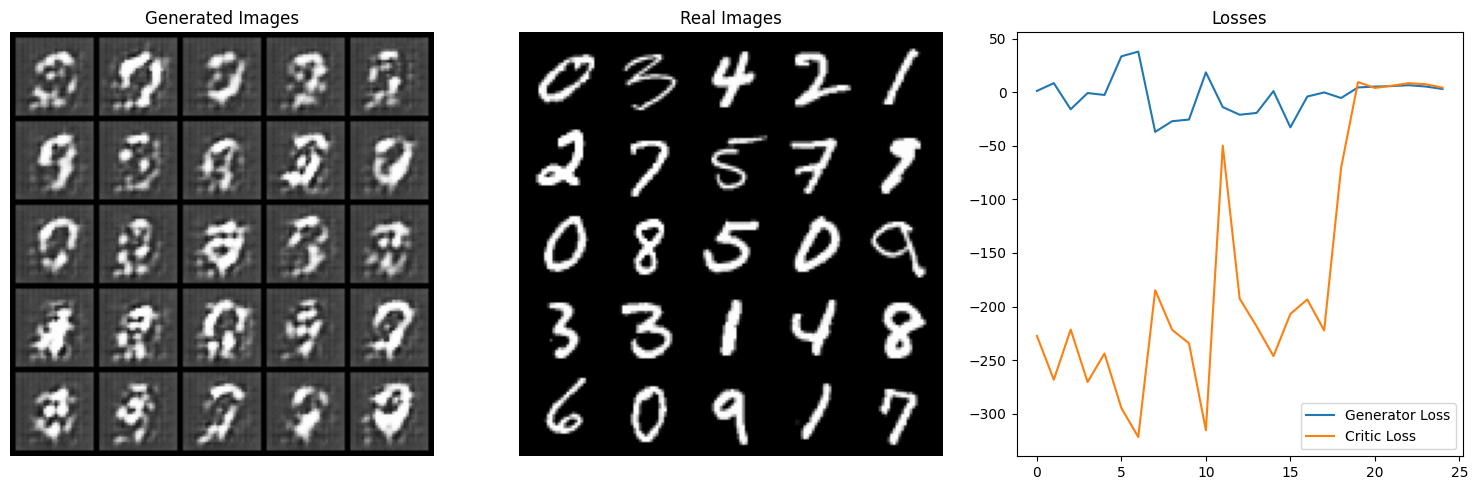

 37%|███▋      | 58/157 [01:27<01:12,  1.37it/s]

Epoch 6, step 1000: Generator loss: -5.100531207039952, critic loss: -54.403382192802425


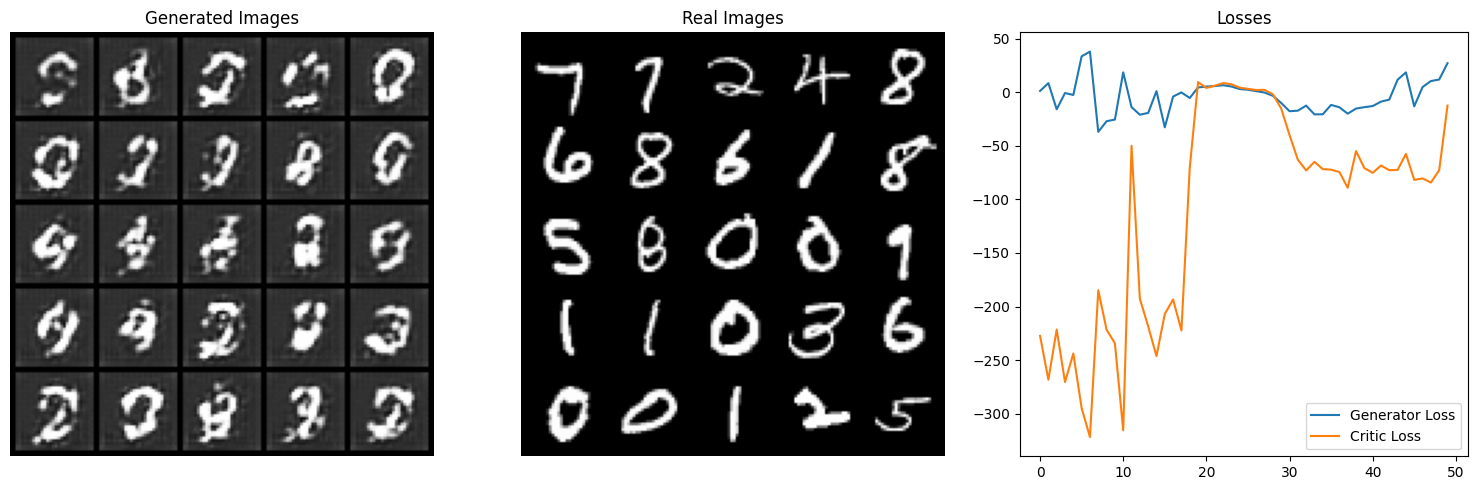

 55%|█████▌    | 87/157 [01:17<00:52,  1.33it/s]

Epoch 9, step 1500: Generator loss: 15.213623998701573, critic loss: -16.157088077926634


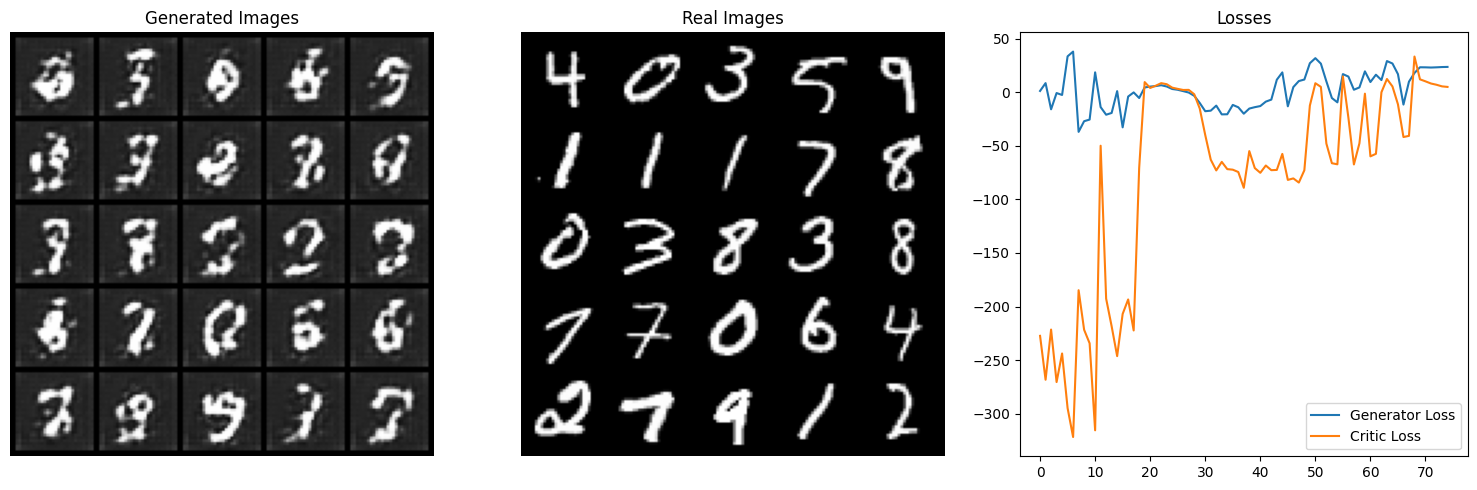

 74%|███████▍  | 116/157 [01:21<00:27,  1.46it/s]

Epoch 12, step 2000: Generator loss: 22.464158493041992, critic loss: 1.6309689569473267


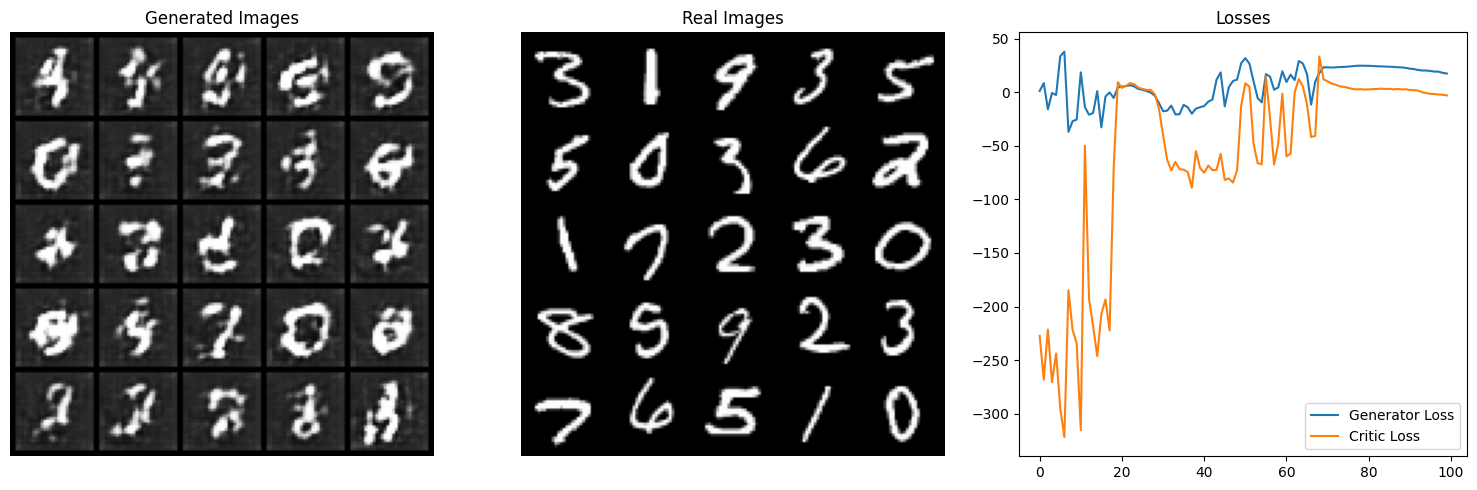

 92%|█████████▏| 145/157 [01:42<00:08,  1.44it/s]

Epoch 15, step 2500: Generator loss: 14.761725457310677, critic loss: -10.819250728797913


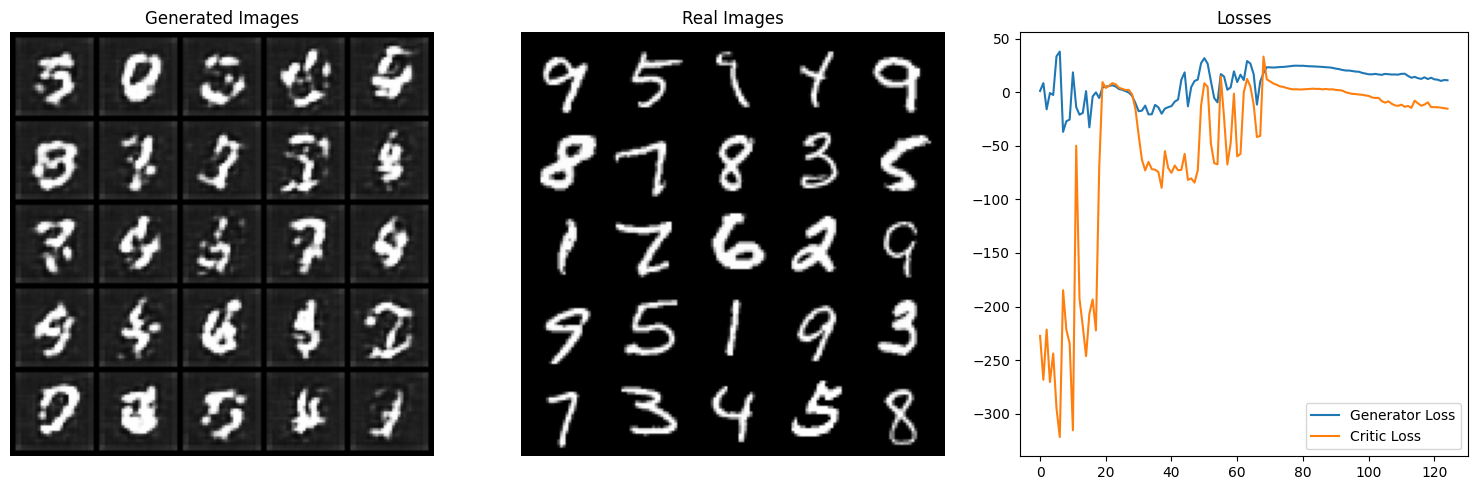

 11%|█         | 17/157 [00:32<04:27,  1.91s/it]

Epoch 19, step 3000: Generator loss: 11.923897582173348, critic loss: -12.626640445661545


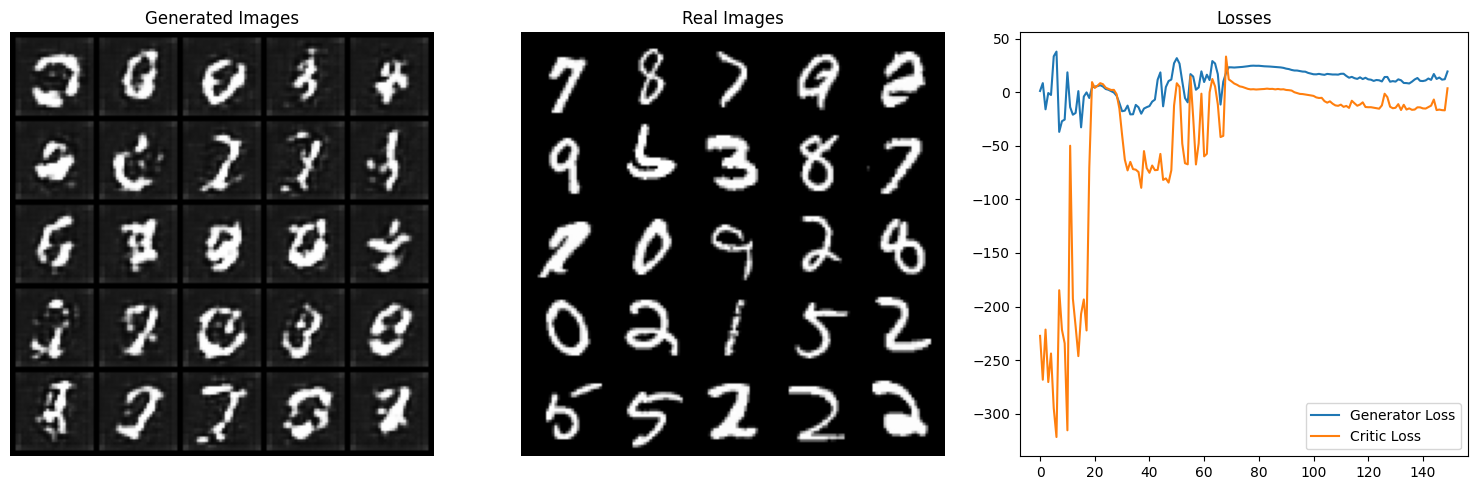

 29%|██▉       | 46/157 [01:15<02:48,  1.52s/it]

Epoch 22, step 3500: Generator loss: 14.96663569688797, critic loss: -8.96641542725563


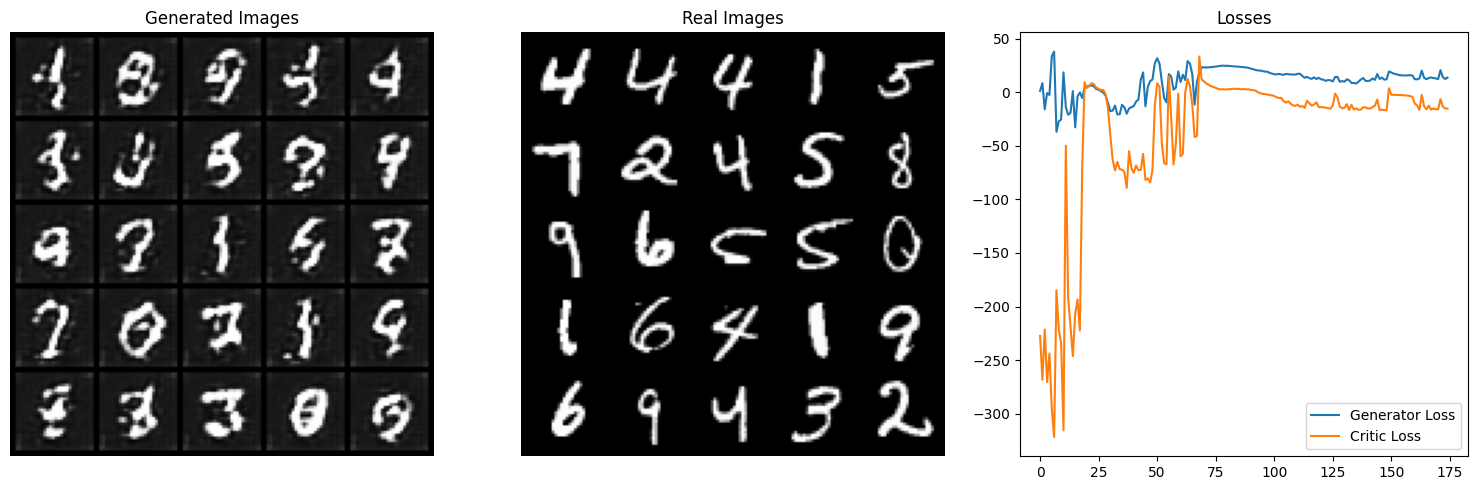

 48%|████▊     | 75/157 [02:05<02:21,  1.73s/it]

Epoch 25, step 4000: Generator loss: 18.018540860652923, critic loss: -5.922274510240555


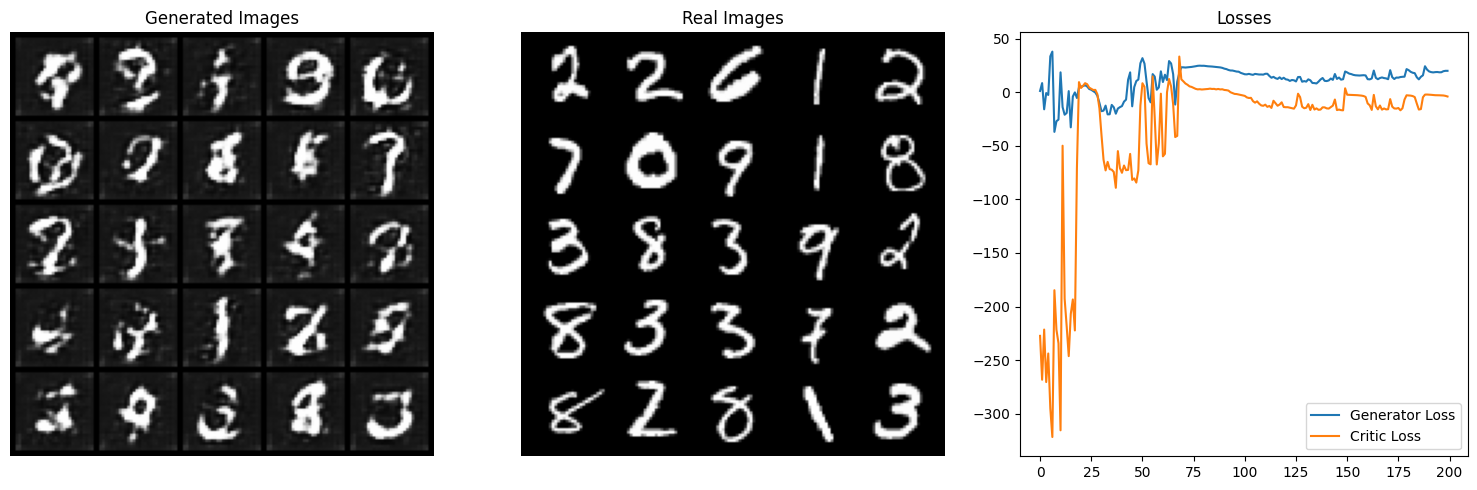

 66%|██████▌   | 104/157 [02:53<01:46,  2.01s/it]

Epoch 28, step 4500: Generator loss: 18.804331254959106, critic loss: -13.103916542053224


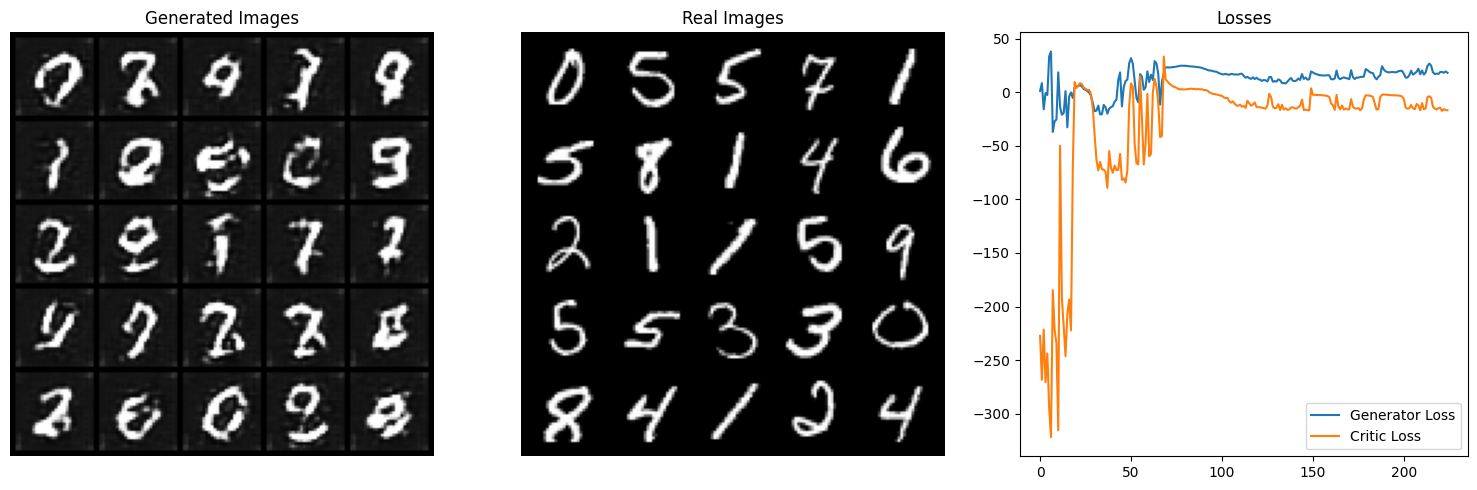

 85%|████████▍ | 133/157 [02:31<00:16,  1.41it/s]

Epoch 31, step 5000: Generator loss: 21.603640322059395, critic loss: -12.767669413518906


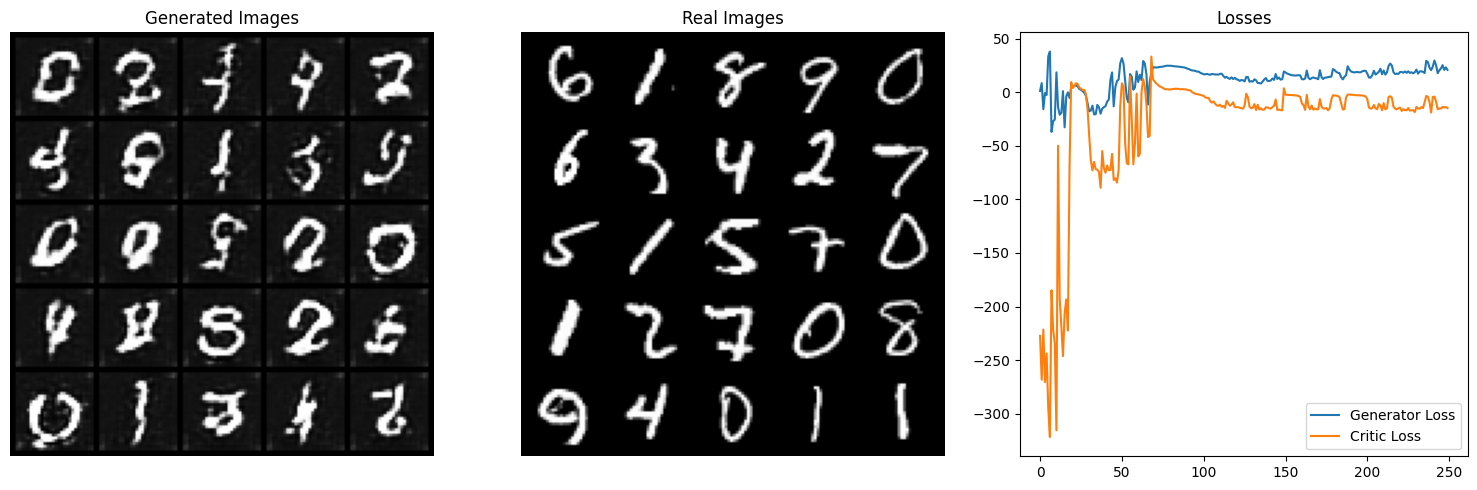

  3%|▎         | 5/157 [00:03<02:00,  1.26it/s]

Epoch 35, step 5500: Generator loss: 23.727487897872926, critic loss: -13.045510679435731


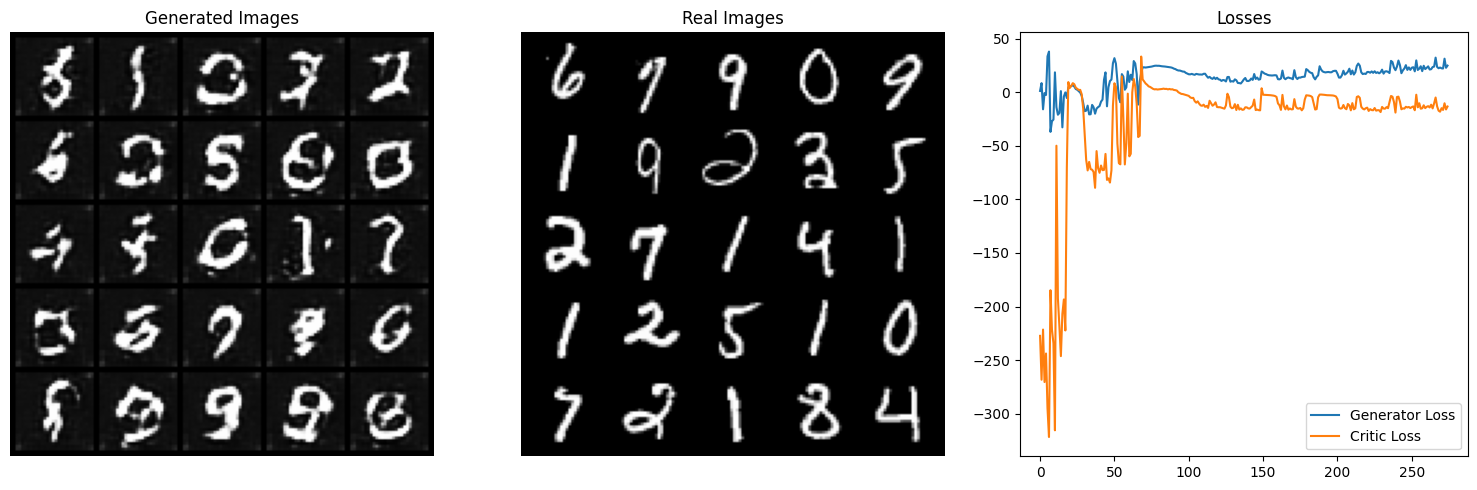

 22%|██▏       | 34/157 [00:23<01:23,  1.47it/s]

Epoch 38, step 6000: Generator loss: 27.46157454299927, critic loss: -8.507961526012421


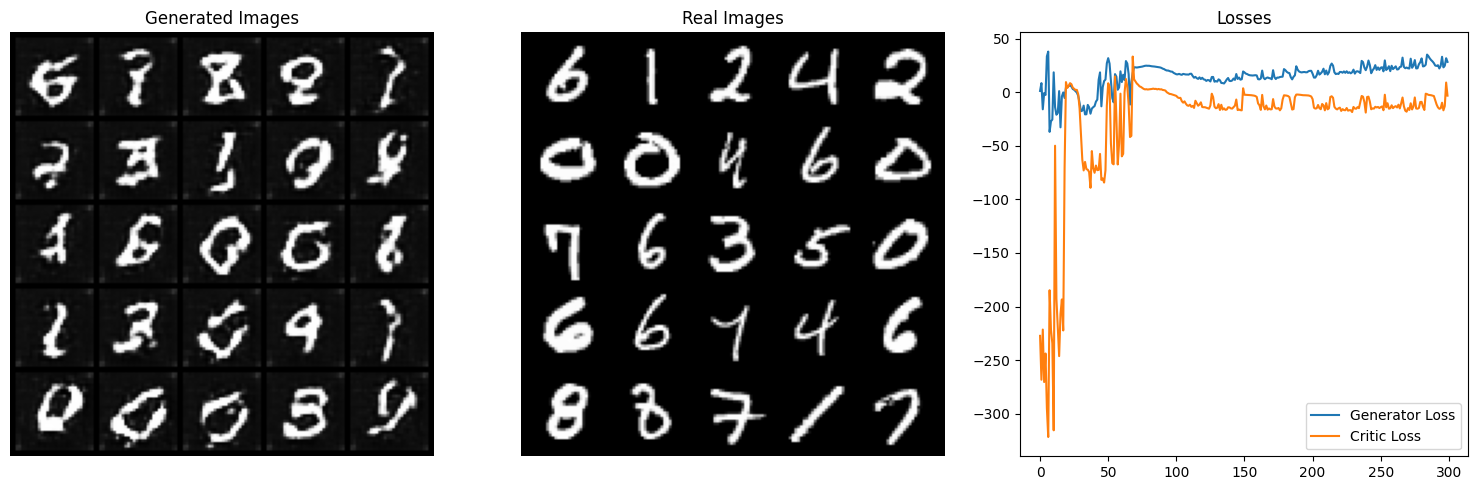

 40%|████      | 63/157 [00:44<01:05,  1.45it/s]

Epoch 41, step 6500: Generator loss: 26.53680874633789, critic loss: -12.685805525898934


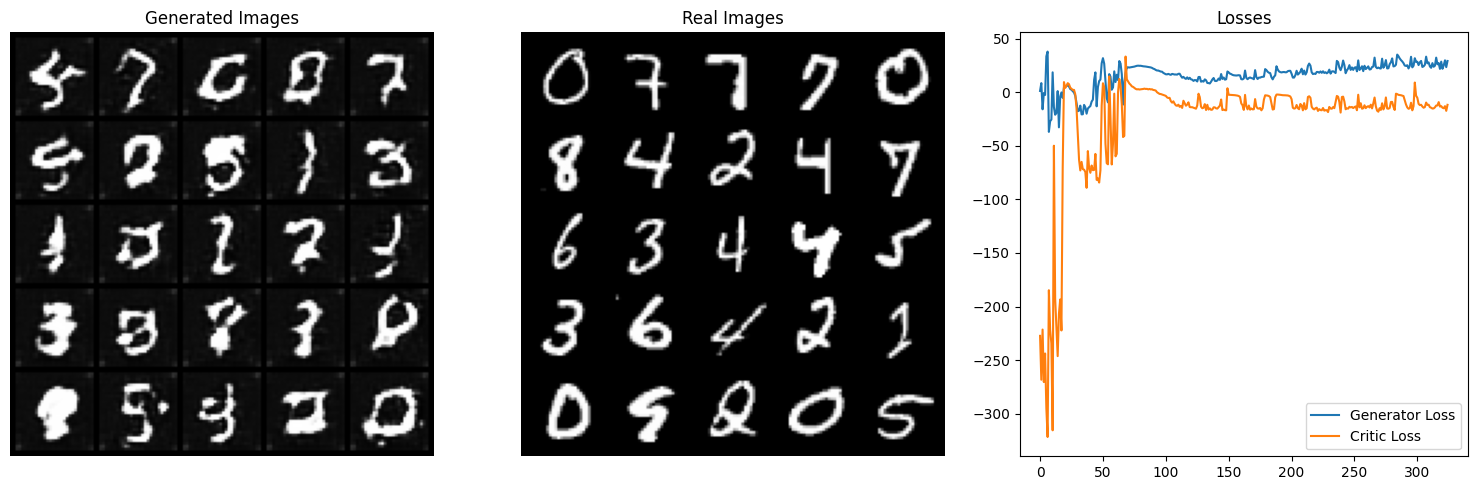

 59%|█████▊    | 92/157 [01:04<00:46,  1.41it/s]

Epoch 44, step 7000: Generator loss: 25.479917894363403, critic loss: -12.428048488020897


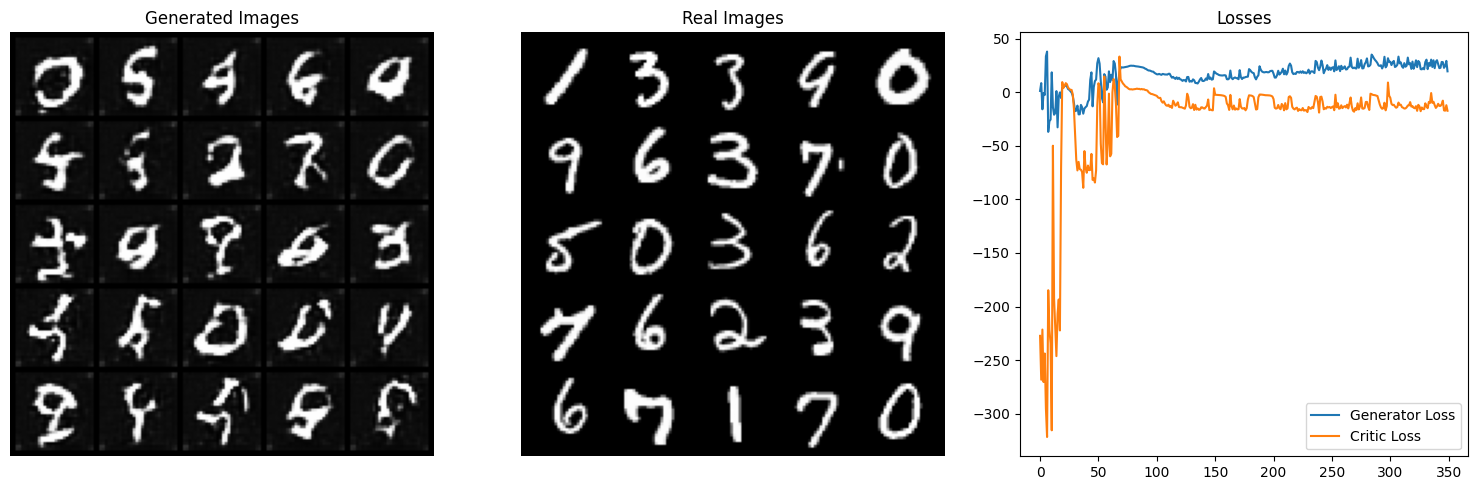

 77%|███████▋  | 121/157 [01:24<00:25,  1.40it/s]

Epoch 47, step 7500: Generator loss: 26.397670433044432, critic loss: -10.40508407611847


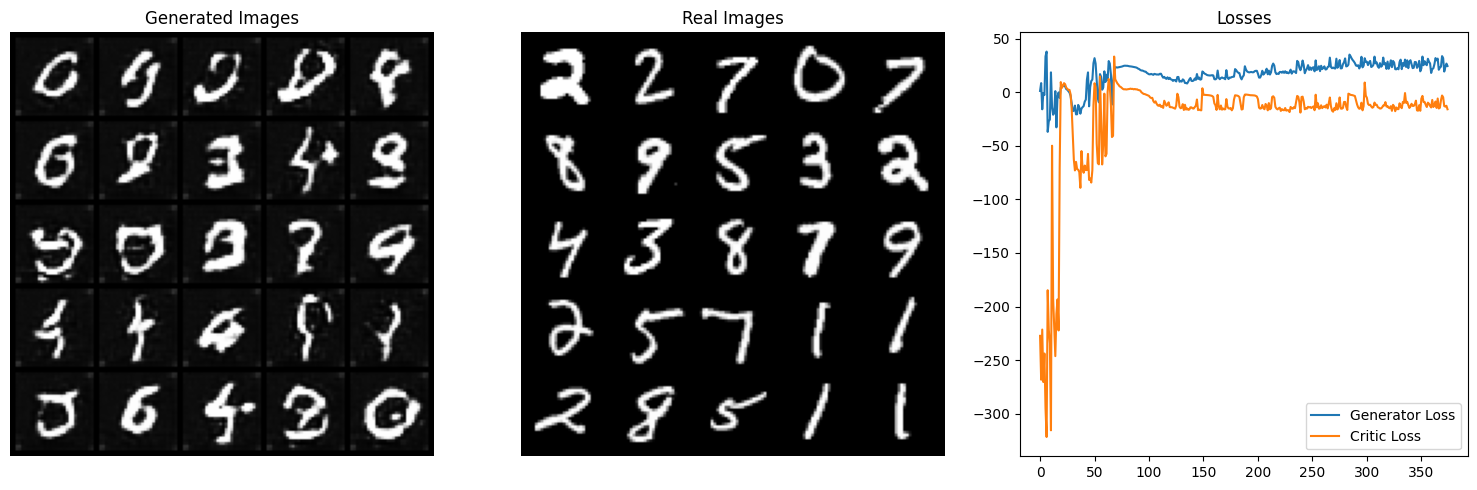

 96%|█████████▌| 150/157 [01:43<00:04,  1.43it/s]

Epoch 50, step 8000: Generator loss: 26.296262035369875, critic loss: -11.264132074666025


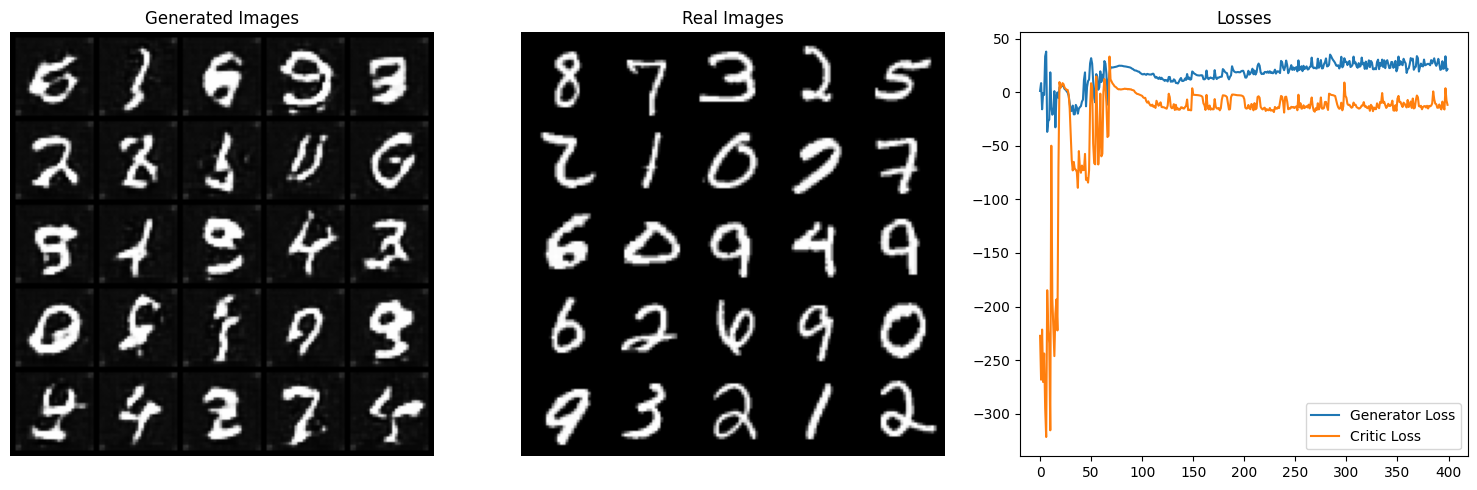

 14%|█▍        | 22/157 [00:15<01:31,  1.47it/s]

Epoch 54, step 8500: Generator loss: 22.94455525350571, critic loss: -10.850918867254256


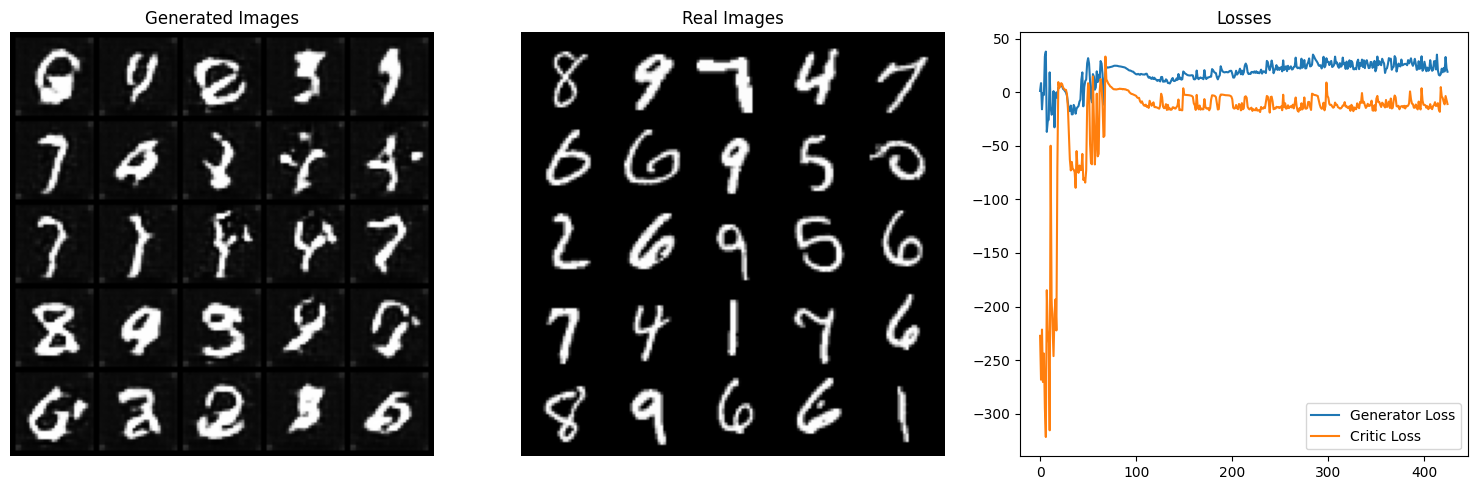

 32%|███▏      | 51/157 [00:35<01:14,  1.42it/s]

Epoch 57, step 9000: Generator loss: 22.18651564025879, critic loss: -11.35043257007599


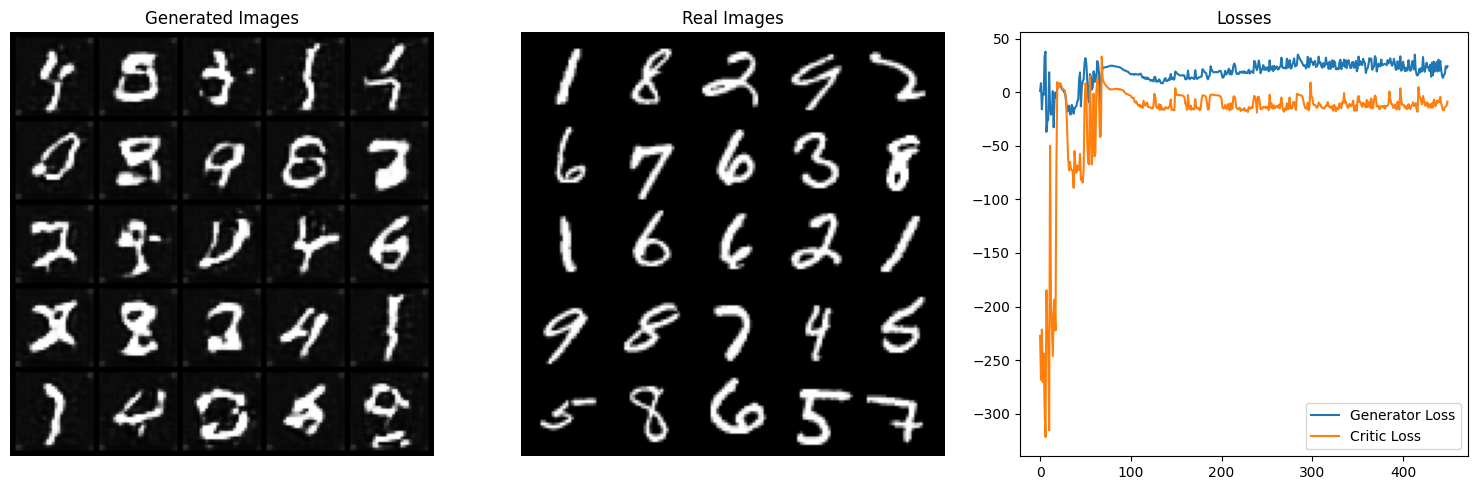

 51%|█████     | 80/157 [00:56<00:54,  1.41it/s]

Epoch 60, step 9500: Generator loss: 18.593241730570792, critic loss: -12.866155370855331


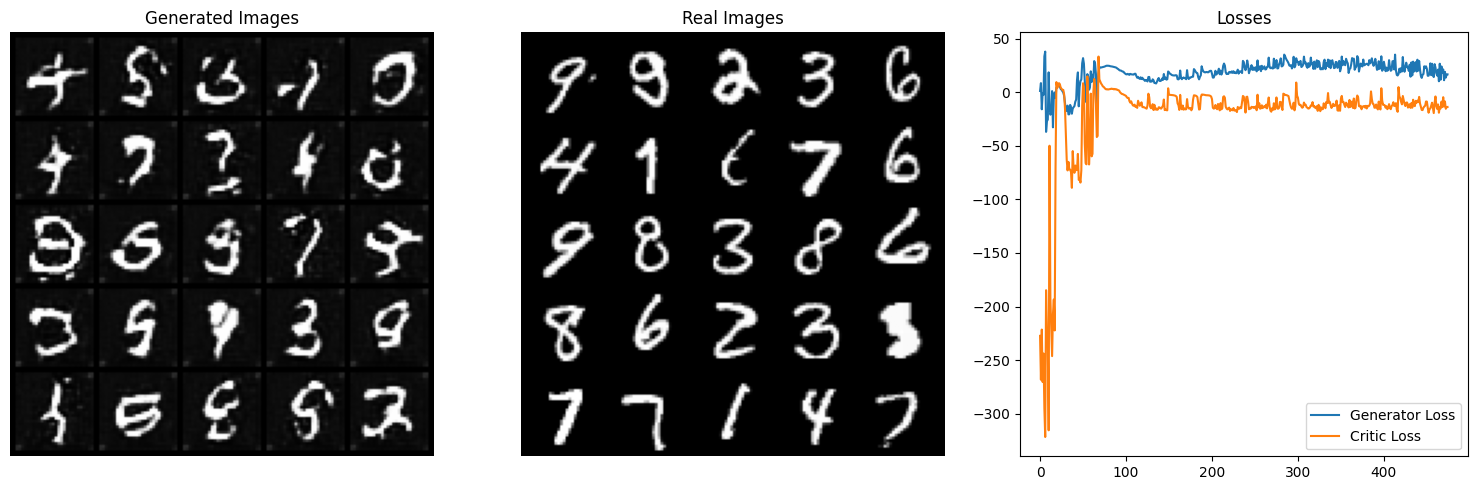

 69%|██████▉   | 109/157 [01:16<00:33,  1.44it/s]

Epoch 63, step 10000: Generator loss: 15.408797509491444, critic loss: -12.52346764128208


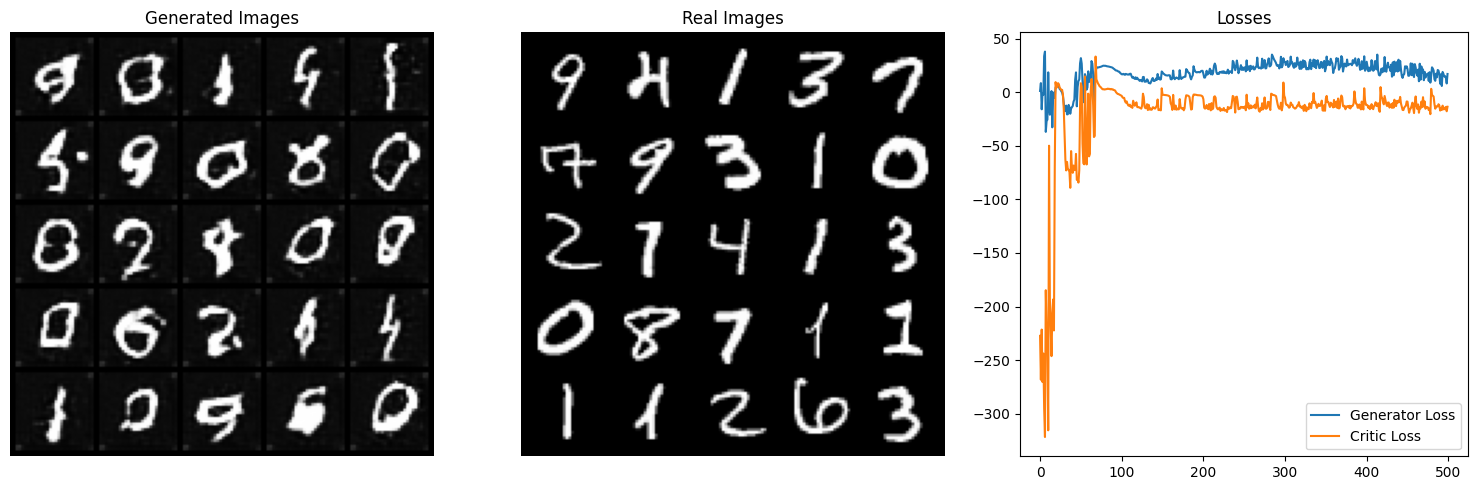

 88%|████████▊ | 138/157 [01:48<00:18,  1.04it/s]

Epoch 66, step 10500: Generator loss: 14.06144358843565, critic loss: -9.850504241585732


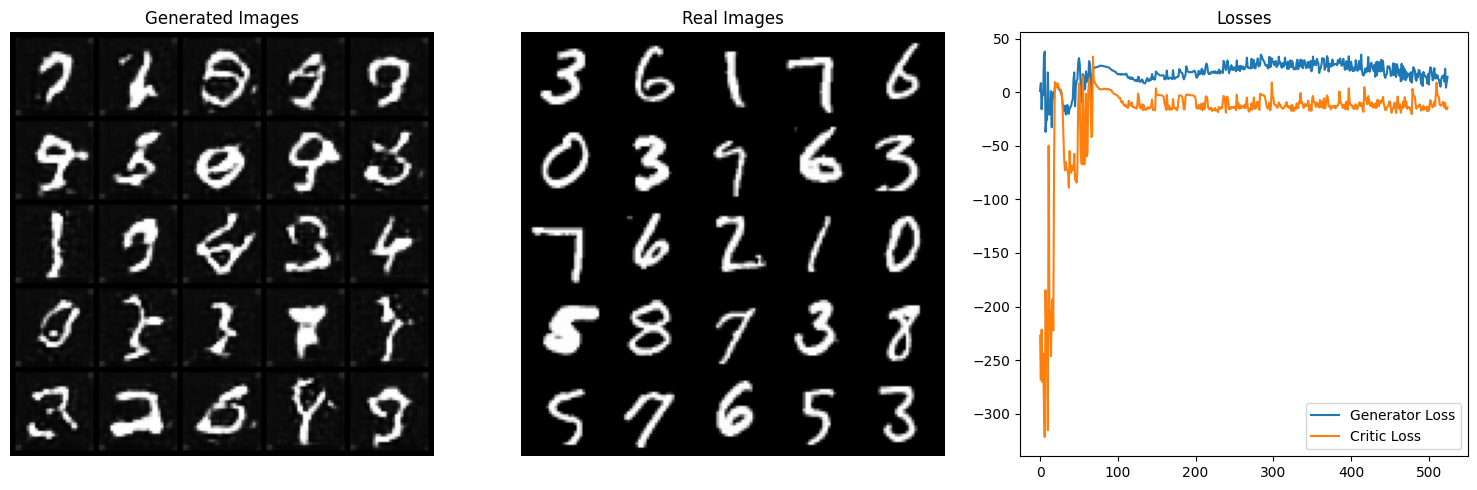

  6%|▋         | 10/157 [00:07<01:46,  1.38it/s]

Epoch 70, step 11000: Generator loss: 9.001812294870614, critic loss: -11.8710411485672


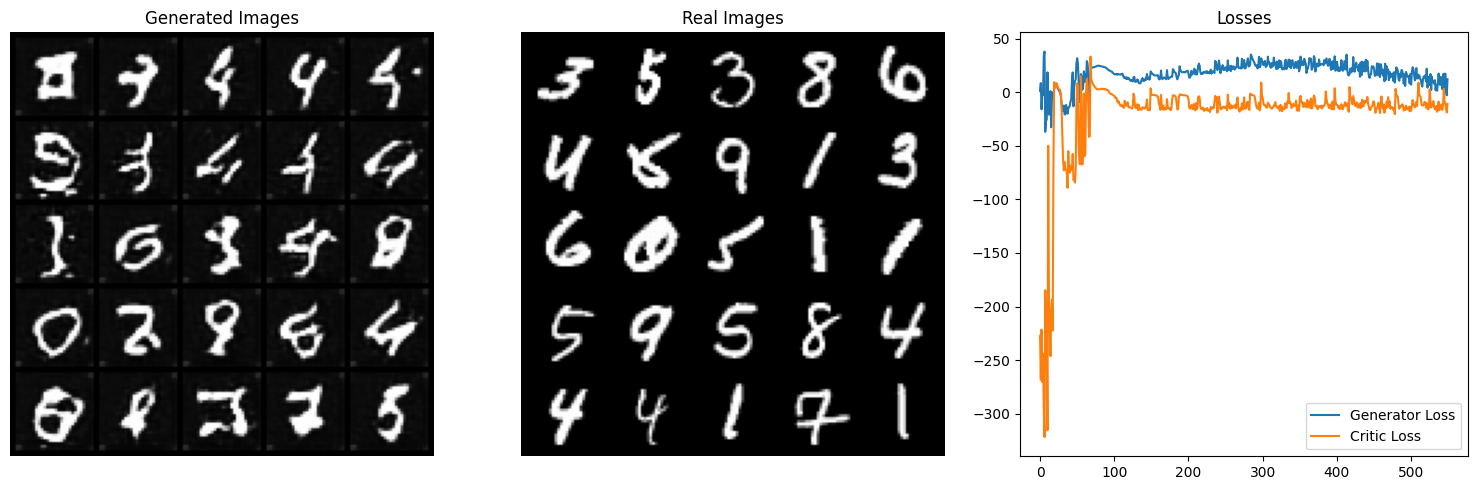

 25%|██▍       | 39/157 [00:27<01:25,  1.39it/s]

Epoch 73, step 11500: Generator loss: 7.8351850645542145, critic loss: -12.306670015001297


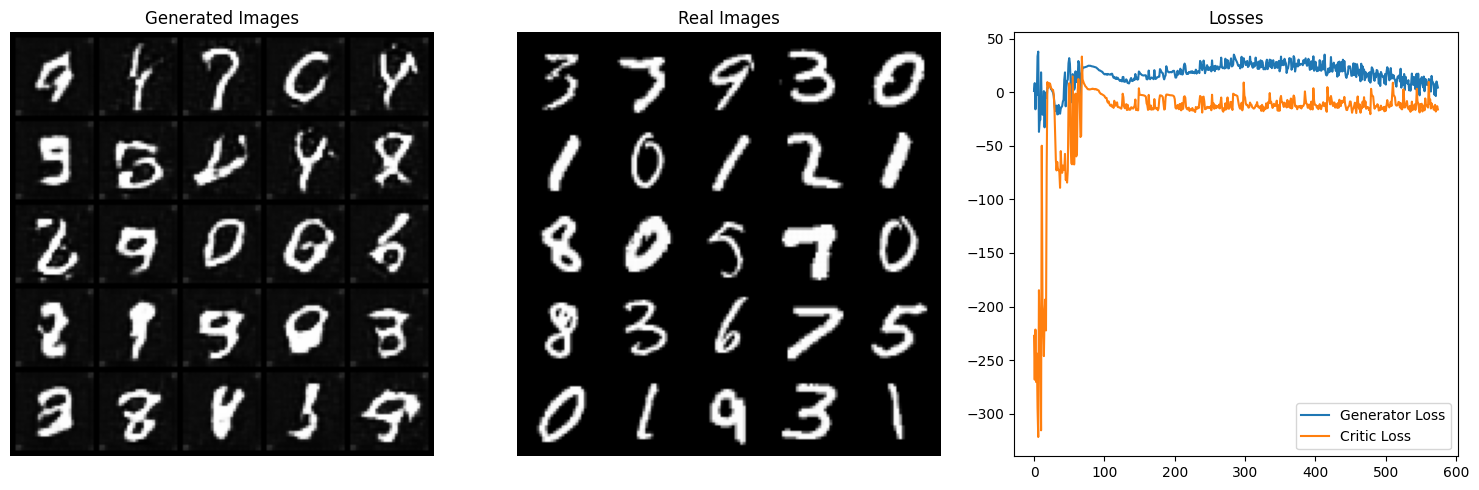

 43%|████▎     | 68/157 [00:49<01:07,  1.33it/s]

Epoch 76, step 12000: Generator loss: 5.851740483671427, critic loss: -12.736265443420411


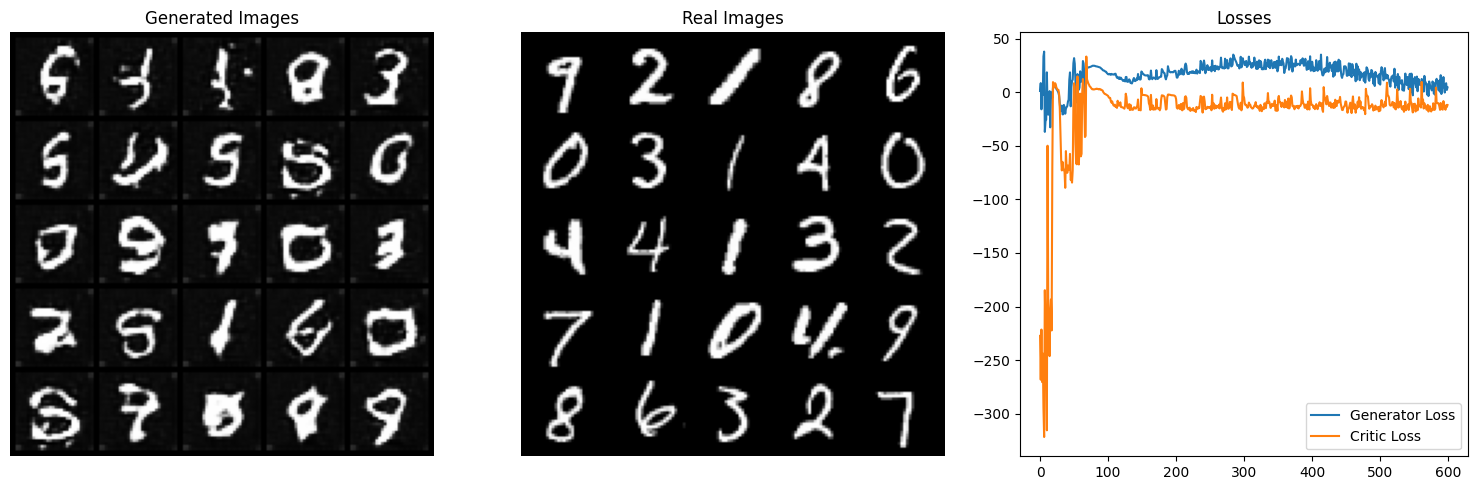

 62%|██████▏   | 97/157 [01:10<00:44,  1.34it/s]

Epoch 79, step 12500: Generator loss: 5.9667021929696205, critic loss: -12.180051601886749


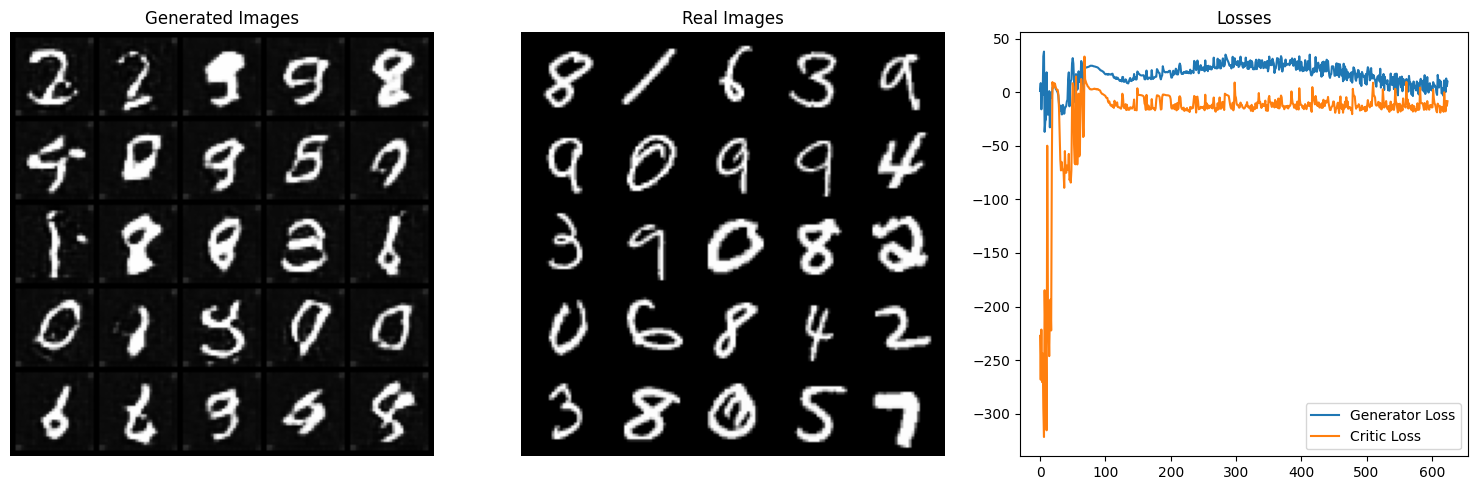

 80%|████████  | 126/157 [01:31<00:22,  1.38it/s]

Epoch 82, step 13000: Generator loss: 5.169450776845217, critic loss: -11.21780115993023


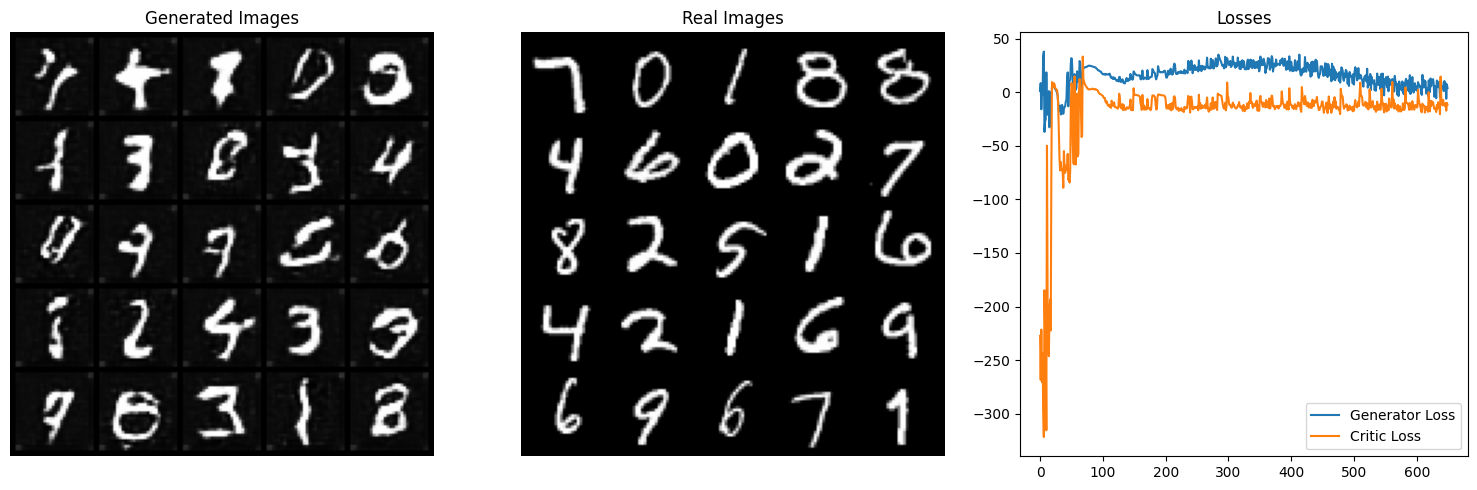

 99%|█████████▊| 155/157 [01:54<00:01,  1.37it/s]

Epoch 85, step 13500: Generator loss: 1.938201740399003, critic loss: -11.134625800275803


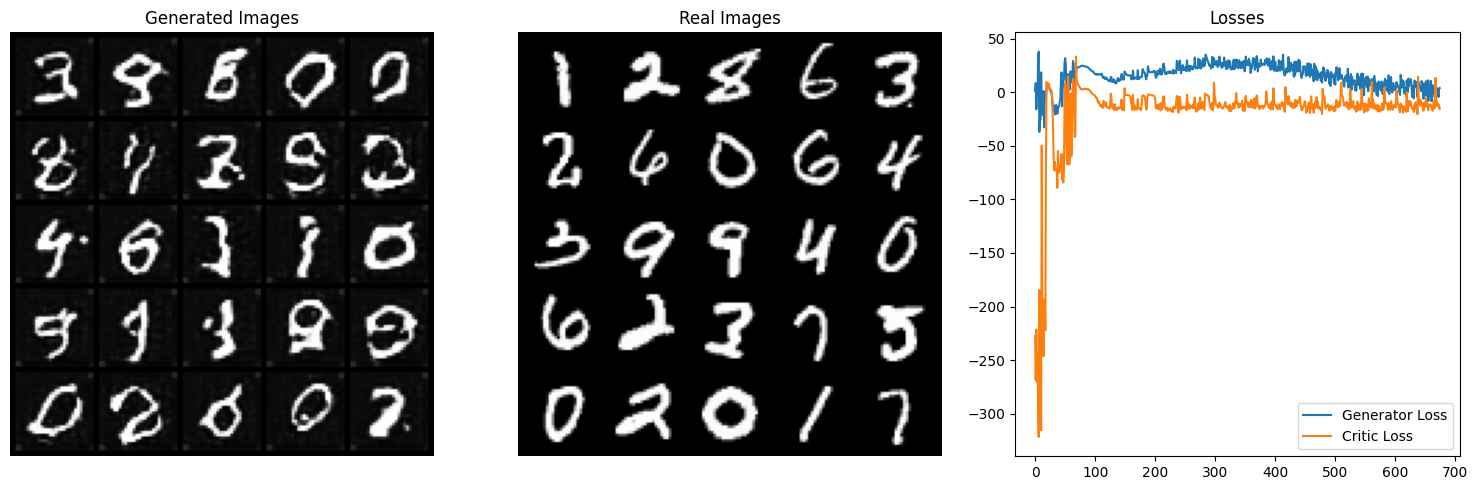

 17%|█▋        | 27/157 [00:19<01:35,  1.36it/s]

Epoch 89, step 14000: Generator loss: 1.326252029761672, critic loss: -11.708564581954478


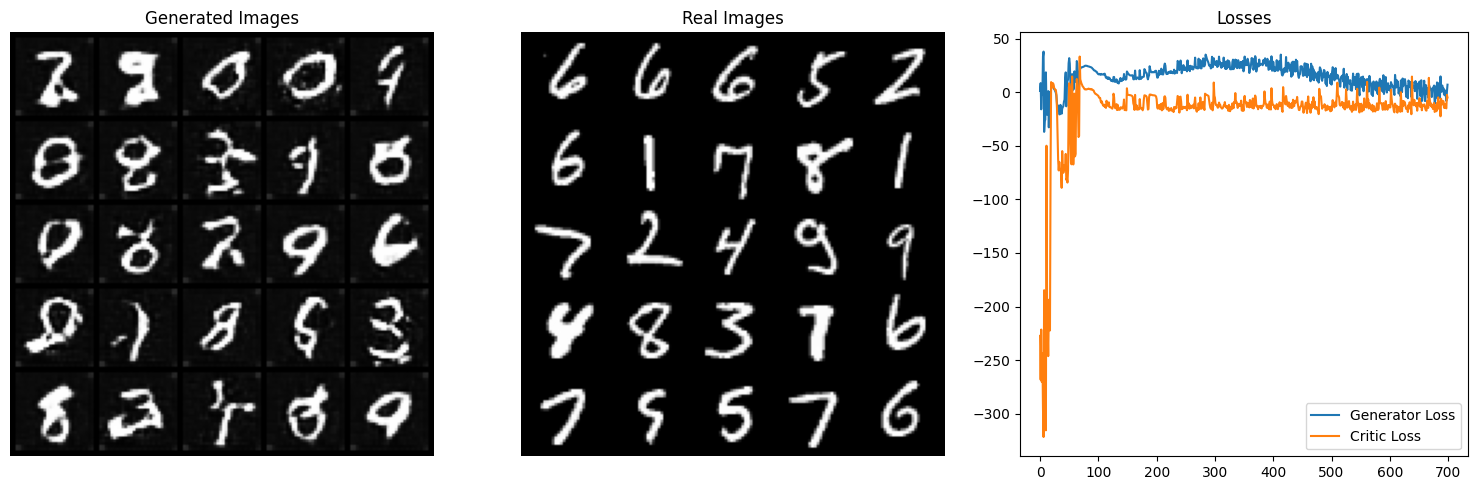

 36%|███▌      | 56/157 [00:40<01:13,  1.38it/s]

Epoch 92, step 14500: Generator loss: -0.971648202508688, critic loss: -12.584381794810295


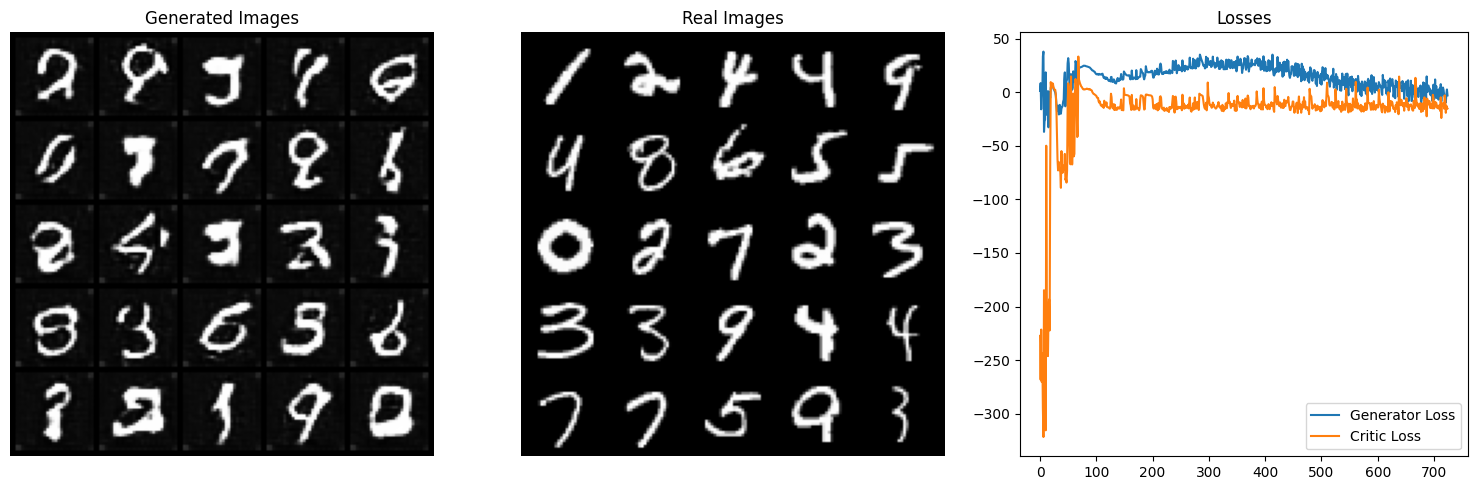

 54%|█████▍    | 85/157 [01:03<00:51,  1.40it/s]

Epoch 95, step 15000: Generator loss: -2.8720725674629213, critic loss: -12.410278950834273


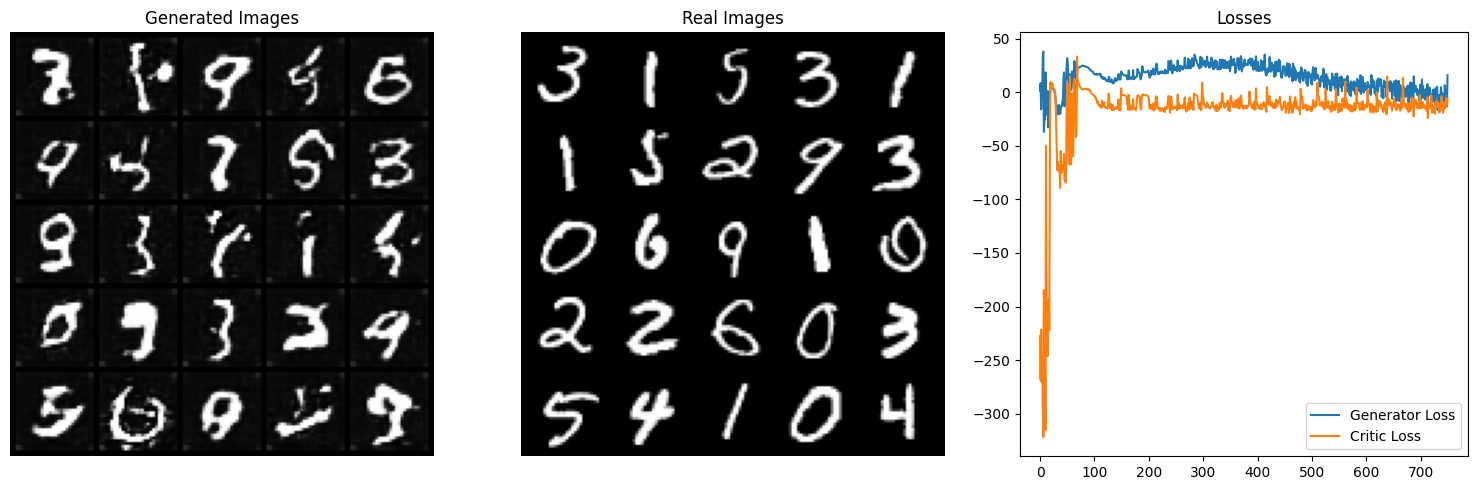

 73%|███████▎  | 114/157 [01:20<00:30,  1.40it/s]

Epoch 98, step 15500: Generator loss: -5.805494418010116, critic loss: -12.777932039999962


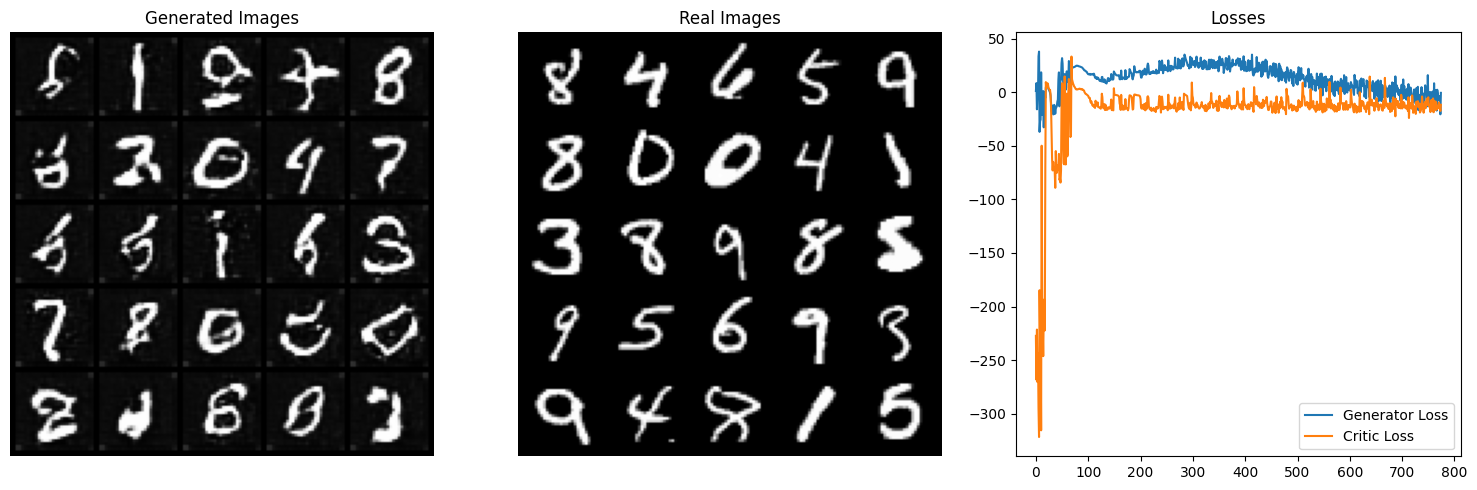

100%|██████████| 157/157 [02:10<00:00,  1.20it/s]


In [ ]:
import matplotlib.pyplot as plt
import os

# Ensure the directory exists
os.makedirs("generated_images", exist_ok=True)

cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            # Plot generated images
            axes[0].set_title("Generated Images")
            fake_images = (fake + 1) / 2  # Rescale to [0, 1]
            fake_grid = make_grid(fake_images[:25], nrow=5)
            axes[0].imshow(fake_grid.permute(1, 2, 0).squeeze())
            axes[0].axis("off")
            
            # Save the fake grid for GIF creation
            fake_grid_image = fake_grid.permute(1, 2, 0).squeeze().cpu().numpy()    
            plt.imsave(f"generated_images/step_{cur_step}.png", fake_grid_image)
            
            # Plot real images
            axes[1].set_title("Real Images")
            real_images = (real + 1) / 2  # Rescale to [0, 1]
            real_grid = make_grid(real_images[:25], nrow=5)
            axes[1].imshow(real_grid.permute(1, 2, 0).squeeze())
            axes[1].axis("off")
            
            # Plot losses
            axes[2].set_title("Losses")
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            axes[2].plot(
            range(num_examples // step_bins), 
            torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
            label="Generator Loss"
            )
            axes[2].plot(
            range(num_examples // step_bins), 
            torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
            label="Critic Loss"
            )
            axes[2].legend()
            
            plt.tight_layout()
            plt.show()

        cur_step += 1


In [ ]:
# Save the generator after training
torch.save(gen.state_dict(), 'generator.pth')
# Save the critic after training
torch.save(crit.state_dict(), 'critic.pth')

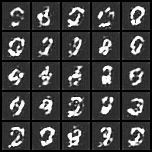

In [1]:
# create a GIF from the saved images
import imageio
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from IPython.display import Image


# Create a GIF from the saved images
def create_gif(image_folder, gif_name, duration=100):
    images = []
    for filename in sorted(glob.glob(os.path.join(image_folder, '*.png'))):
        img = Image.open(filename)
        images.append(img)
    images[0].save(gif_name, save_all=True, append_images=images[1:], duration=duration, loop=0)

# Create the GIF
display(Image(filename='generated_images.gif'))
    

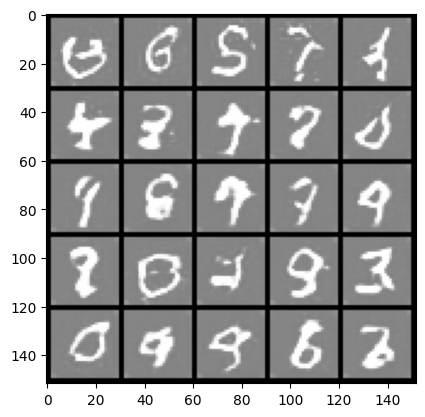

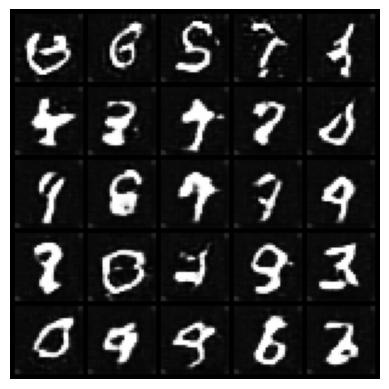

In [ ]:
# Make sure the model structure matches
gen = Generator(z_dim=z_dim).to(device)
gen.load_state_dict(torch.load('generator.pth'))
gen.eval()


# Generate new images using the trained generator
with torch.no_grad():
    noise = get_noise(25, z_dim, device=device)
    generated_images = gen(noise)
    generated_images = (generated_images + 1) / 2  # Rescale to [0, 1]
    show_tensor_images(generated_images, num_images=25, size=(1, 28, 28))
    # Save the generated images
    grid = make_grid(generated_images[:25], nrow=5)
    plt.imshow(grid.permute(1, 2, 0).squeeze())
    plt.axis("off")
    plt.show()
